In [1]:
using ForwardDiff
using PyPlot
using LinearAlgebra

# Automatic Differentiation
Automatic Differentation is a set of techniques to compute derivatives efficiently dating back to the 1960s. Different from numerical differentation using finite differences, or symbolic differentiation using a library like SymPy or MATLAB, or manually by hand. Automatic differentiation calculates the derivative of a function $f(x)$ at a particular value of $x$, forgoing the analytical closed form solution we might be used to from manual differentiation. 

The idea is to break up a function $f(x, y)$ into its simplest operations such as addition, subtraction, division, exponentiation, etc and then use the derivatives of these elementary operations to compute a certain derivative of the function. For example say we have the function, 
$$
f(x_1, x_2) = x_2 \sin(x_1) + x_2^2
$$
and we want to know the derivative of this function with respect to $x_1, \frac{\partial f}{\partial x_1}$. We can think of $f(x_1, x_2)$ as a set of nested functions or _primals_, like so:
$$
\begin{align}
f(x_1, x_2) &= f_2(f_1(f_0(x_1))) = f_2(f_1(w_0)) = f_2(w_1) = r\\
f_0(x_1) &= \sin(x_1) = w_0\\
f_1(w_0) &= x_2 w_0 = w_1 \\
f_2(w_1) &= w_1 + x_2^2 = r 
\end{align}
$$

Then we can describe the derivative of this function with respect to either of the input variables as: 
$$
\begin{align}
% derivative with respect to x_1
\frac{\color{red}{\partial  f}}{\color{blue} {\partial  x_1}} &= 
\frac{\color{red}{\partial  f}}{\partial w_1}
\frac{\partial w_1}{\color{blue} {\partial  x_1}} =
\frac{\color{red}{\partial  f}}{\partial w_1}
\frac{\partial w_1}{\partial w_0}
\frac{\partial w_0}{\color{blue} {\partial  x_1}}\\
\end{align}
$$
We can perform this computation in the forward direction starting with $\frac{\partial f}{ {\partial w_1}}$, or in the reverse direction starting with $\frac{\partial w_0}{ {\partial  x_1}} $. 

We can represent these primal functions in a _computation graph_ which gives us a view of the operations occuring when computing the function. 
![compute graph](images/computation_graph.png)

## Forward Mode
To start with the forward mode, we again list out the _primal_ functions of $f(x_1, x_2)$: 
$$
\begin{align}
w_0 &= sin(x_1) \\
w_1 &= x_2 w_0 \\
w_2 &= x_2^2 \\
r &= w_1 + w_2
\end{align}
$$
While calculating these primal functions we keep a record of the derivatives, or _tangent_ functions of $f(x_1, x_2)$ where $\dot{w_0} = \frac{\partial w_0}{\partial x_1}$. Keep in mind that we can keep track of our "seeds" $\dot{x_1} = \frac{\partial x_1}{\partial x_1} = 1, \dot{x_2} = \frac{\partial x_2}{\partial x_1} = 0$: 
$$
\begin{align}
\dot{w_0} &= cos(x_1) \cdot \dot{x_1} = \cos(x_1) \\
\dot{w_1} &= x_2 \dot{w_0} + \dot{x_2} w_0 = x_2 \cdot \cos(x_1)\\
\dot{w_2} &= 2 x_2 \cdot \dot{x_2} = 0\\
r &= \dot{w_1} + \dot{w_2} = x_2 \cdot \cos(x_1)
\end{align}
$$
using the chain rule and product rule where appropriate. This now gives us the value of $\frac{\partial f}{\partial x_1}$ at analytical accuracy. 

In order to solve for $\frac{\partial f}{\partial x_2}$, we can use the same primal functions, but this time our seeds are $\dot{x_1} = \frac{\partial x_1}{\partial x_1} = 0, \dot{x_2} = \frac{\partial x_2}{\partial x_1} = 1$, which gives us: 
$$
\begin{align}
\dot{w_0} &= cos(x_1) \cdot \dot{x_1} = 0 \\
\dot{w_1} &= x_2 \dot{w_0} + \dot{x_2} w_0 = \sin(x_1)\\
\dot{w_2} &= 2 x_2 \cdot \dot{x_2} = 2 x_2\\
r &= \dot{w_1} + \dot{w_2} = \sin(x_1) + 2x_2
\end{align}
$$

## Reverse Mode
To perform the reverse auto diff, or _adjoint_ derivative, we start with the adjoint derivative $\bar{f}$:
$$
\begin{align}
\bar{f} &= \frac{\partial f}{\partial f} = 1 \\
\end{align}
$$
Our goal is to find the adjoints of our input variables which we found using forward autodiff above: 
$$
\begin{align}
\bar{x_1} &= \frac{\partial f}{\partial x_1} \\
\bar{x_2} &= \frac{\partial f}{\partial x_2} \\
\end{align}
$$

This uses the computation graph as a reference to compute the adjoint derivatives. 
![reverse diff](images/reverse_autodiff.png)

The reverse mode requires us to calculate the primal functions in a forward pass. Afterwards we perform a reverse pass to calculate the adjoint derivatives of the primals. In other words instead of computing the derivatives simultaneous to the forward pass, we store values and dependencies of intermediate variables:
$$
\begin{align}
w_0 &= sin(x_1) \\
w_1 &= x_2 w_0 \\
w_2 &= x_2^2 \\
r &= w_1 + w_2
\end{align}
$$
In order to calculate $\bar{w_i}$ for a particular primal function, or node in the computation graph, we look at the nodes children: 
$$
\bar{w_i} = \frac{\partial f}{\partial w_i} = \sum_{j \textrm{ child of } i} \bar{w_j} \frac{\partial w_j}{\partial w_i}
$$

Starting from the last expression and applying the formula for adjoint derivatives of nodes: 
$$
\begin{align}
% w1
\bar{w_1} &= \bar{r}\frac{\partial r}{\partial w_1} &\bar{r}\frac{\partial r}{\partial w_1} &= 1 \cdot \frac{\partial}{\partial w_1}[w_2 + w_1] =  1\\
% w2
\bar{w_2} &= \bar{r}\frac{\partial r}{\partial w_2} &\bar{r}\frac{\partial r}{\partial w_2} &= 1 \cdot \frac{\partial}{\partial w_1}[w_2 + w_1] =  1\\
% w0
\bar{w_0} &= \bar{w_1} \frac{\partial w_1}{\partial w_0} & \bar{w_1}\frac{\partial w_1}{\partial w_0} &= 1 \cdot \frac{\partial}{\partial w_0}[x_2 w_0] = x_2\\
% x1
\bar{x_1} &=  \bar{w_0}\frac{w_0}{\partial x_1} & \bar{w_0}\frac{w_0}{\partial x_1}&= x_2 \cdot\frac{\partial}{\partial x_1}[ \sin{x_1}] = x_2 \cdot \cos(x_1) \\
% x2
\bar{x_2} &= \bar{w_1} \frac{\partial w_1}{\partial x_2} + \bar{w_2} \frac{\partial w_2}{\partial x_2} & &= 1 \cdot\frac{\partial}{\partial x_2}[x_2 w_0] + 1 \cdot\frac{\partial}{\partial x_2}[x_2^2]= \sin(x_1) + 2x_2\\
\end{align}
$$

We can see that by making use of the reverse automatic differentiation and the adjoint derivatives, we actually obtain the same derivatives we computed in the forward pass above. However, using the reverse pass we obtain both derivatives $\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}$ in one pass, whereas we need to perform two passes just using the forward pass. 

This fact makes reverse mode autodiff better to use when the number of inputs far exceeds the number of outputs, as is typical in machine learning. For general vector valued functions, reverse mode produces one row of the Jacobian at a time, whereas forward mode produces a single column. 

There are other types of mixtures between forward and reverse mode autodiff such as forward-on-reverse autodiff. Additionally, some of the algebra can be computed using _dual_ numbers, which is how Julia's `ForwardDiff.jl` is implemented. 

## ForwardDiff.jl
There are a couple ways to implement this from scratch, including operator overloading, and source code conversion. However, it's often easiest to use a pre-written library. In Julia there is `ForwardDiff`, Python has `autograd`, and various machine learning engines such as TensorFlow and PyTorch have their own automatic differentiation implementations. 

Julia is particularly well suited for autodifferentiation because of multiple dispatch, which overloads math functions and can store their partial derivatives. ForwardDiff is much faster than `autograd` when the input size is smaller than around 10000.

### Derivatives
Say we want to graph the function $g(x)$ and its derivative:

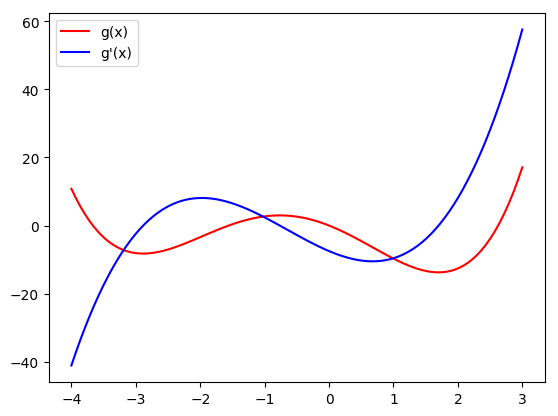

PyObject <matplotlib.legend.Legend object at 0x7efd9a47a860>

In [2]:
g(x) = 0.5x^4 + 1.3x^3 -4.0x^2 - 7.5x + 0
∇g(x) = ForwardDiff.derivative(g, x)

xs = LinRange(-4, 3, 100)
# vectorize along the arrays
ys = g.(xs)
ys_prime = ∇g.(xs)
plot(xs, ys, "r", label="g(x)")
plot(xs, ys_prime, "b", label="g'(x)")
legend()

### Gradients
Now to get fancier, let's graph a contour map and vector field of the function we worked with earlier with the `ForwardDiff.gradient` function. 

In [3]:
# calculate function at particular x
f(x) = x[2] * sin(x[1]) + x[2]^2
# use autodiff to calculate the derivative
∂f(x) = ForwardDiff.jacobian(f, x)
∇f(x) = ForwardDiff.gradient(f, x)

∇f (generic function with 1 method)

With this function, we can calculate the gradient at every point in the graph so that we can obtain a vector field. The gradient is a directional vector that describes the change of the function in all directions:
$$
\nabla f(x_1, x_2) = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} 
\end{bmatrix}
$$
As discussed before, in order to solve for this with forward mode autodiff we would need to perform two forward passes. 

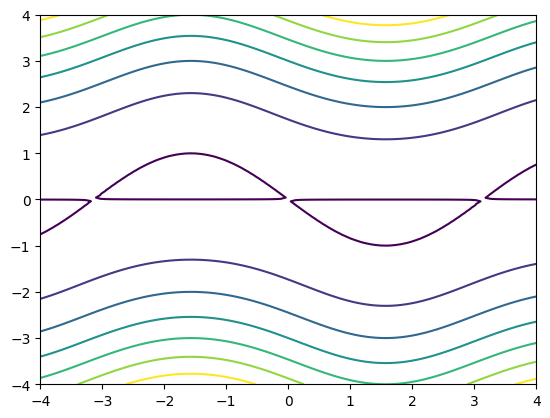

PyObject <matplotlib.contour.QuadContourSet object at 0x7efe093ac160>

In [4]:
# create contour map of the function f(x)
function plot_source_landscape(fun)
    n, up, low = 100, -4, 4
    # calculate outer product to make a meshgrid
    x = ones(n) * LinRange(low, up, n)'
    y = LinRange(low, up, n) * ones(n)'
    # use array comprehension to populate z array
    z = [fun([x[i, j]; y[i, j]]) for i = 1:n, j=1:n]
    contour(x, y, z)
end
plot_source_landscape(f)

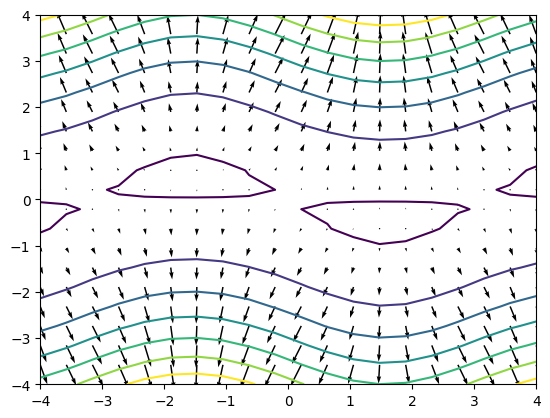

PyObject <matplotlib.quiver.Quiver object at 0x7efe0931da20>

In [5]:
# now add on the gradient field
function plot_gradient_landscape(fun, fun_grad)
    n, up, low = 20, -4, 4
    # calculate outer product to make a meshgrid
    x = ones(n) * LinRange(low, up, n)'
    y = LinRange(low, up, n) * ones(n)'
    # use array comprehension to populate z array
    z = [fun([x[i, j]; y[i, j]]) for i = 1:n, j=1:n]
    # get the normals
    u = [fun_grad([x[i, j]; y[i, j]])[1] for i = 1:n, j=1:n]
    v = [fun_grad([x[i, j]; y[i, j]])[2] for i = 1:n, j=1:n]
    # scale u, v
    u
    v

    contour(x, y, z)
    quiver(x, y, u, v)
end
# see the gradients along with the original function
plot_gradient_landscape(f, ∇f)

### Jacobians
We can also find jacobians for linearizing vector valued functions. Take the simple example: 
$$
g(x) = 
\begin{bmatrix}
2 x_1^2 \\
-x_2^3 + x_1
\end{bmatrix}
$$

The Jacobian of this function with respect to $x$ is: 

$$
\frac{\partial g}{\partial x} = 
\begin{bmatrix}
\frac{\partial g_1}{\partial x_1} & \frac{\partial g_1}{\partial x_2} \\
\frac{\partial g_2}{\partial x_1} & \frac{\partial g_2}{\partial x_2}
\end{bmatrix}
= 
\begin{bmatrix}
4 x_1 & 0 \\
1 & -3 x_2^2
\end{bmatrix}
$$


In [6]:
g(x) = [2*x[1]^2, -x[2]^3 + x[1]]
∂g(x) = ForwardDiff.jacobian(g, x)

∂g (generic function with 1 method)

In [7]:
x0 = [0.4, 0.5]
println("g(x): ", g(x0))
println("Jacobian of g(x): ", ∂g(x0))

g(x): [0.32000000000000006, 0.275]
Jacobian of g(x): [1.6 0.0; 1.0 -0.75]


Which matches what we would predict from analytically deriving the Jacobian. 

Now say we had a function representing the dynamics of a pendulum $\dot{x} = f(x, u)$:
$$ 
x = \begin{bmatrix}
\theta \\
\dot{\theta}
\end{bmatrix}, \quad
\dot{x} = \begin{bmatrix}
\dot{\theta} \\
\ddot{\theta}
\end{bmatrix}
$$
$$
\dot{x} = f(x, u) = \begin{bmatrix}
\dot{\theta} \\
-\frac{g}{l} \sin\theta + \frac{1}{m l^2} u
\end{bmatrix}
$$

where $l$ is the length of the pendulum, $g$ is the acceleration due to gravity, $\theta$ is the angle the swinging mass $m$ makes with the vertical, and $u$ is a control force. 

Linearizing these dynamics can be done using the jacobian $A \approx \frac{\partial f}{\partial x}, B = \frac{\partial f}{\partial u}$. For the pendulum, this looks like:
$$ \dot{x} = \begin{bmatrix}
0 & 1 \\
-\frac{g}{l} \cos(\theta) & 0
\end{bmatrix} x + 
\begin{bmatrix}
0 \\
\frac{1}{m l^2}\end{bmatrix} u. 
$$
Effectively, computing the $B$ matrix is a Jacobian that ignores the other two variables in the dynamics function. In order to use ForwardDiff, we need to rewrite the dynamics to only take in one vector $x$. We can then take the derivative of the entire function with respect to all three variables, and slice it up to get $A, B$. So we can either rewrite the dynamics function as $f_{auto}$, 

$$
f_{auto}(x) = \begin{bmatrix}
{x_2} \\
-\frac{g}{l} \sin x_1 + \frac{1}{m l^2} x_3
\end{bmatrix}
$$

In [8]:
# constants set
grav = 9.81
l = 1
m = 1
fₐ(x) = [x[2], -(grav/l)*sin(x[1]) + (1/m*l^2)x[3]]

fₐ (generic function with 1 method)

In [9]:
x = [1.0, 1.0, 1.0]
J = ForwardDiff.jacobian(fₐ, x)
A = J[:, 1:2]
B = J[:, 3]
println("A: ", A)
println("B: ", B)

A: [0.0 1.0; -5.300365620566452 0.0]
B: [0.0, 1.0]


Or we can just leave it in the form $f(x, u)$, but with an anonymous function in the `ForwardDiff.jacobian(f, x)` call. 

In [10]:
# alternatively, just do something like this:
fₚ(x, u) = [x[2], -(grav/l)*sin(x[1]) + (1/m*l^2)u]
# just as before, first 2x2 is A, second 2x1 is B
J = ForwardDiff.jacobian(i -> fₚ([i[1], i[2]], i[3]), x)

2×3 Matrix{Float64}:
  0.0      1.0  0.0
 -5.30037  0.0  1.0

### Aside on Pendulum Dynamics
When producing the phase portrait of the pendulum's dynamics, we want to plot $\theta$ vs $\dot{\theta}$ and observe the behavior. We notice that there are clearly some sources and sinks in the dynamics. We can use the functions `quiver` and `streamplot` to plot the phase space. Since both methods of plotting ask for velocities $u, v$ of the input variables, we can calculate these as, 

$$
u = \dot{\theta} = x_2 \qquad v = \ddot{\theta} = -\frac{g}{l} \sin x_1
$$

which is just the system dynamics. When viewing streamlines, it's important to note that the lines are representing the phase path a particle will take given any initial starting position. A stream line joins together the velocity field which makes it look exactly like the original path. This makes it simple to identify equilibrium points. 

In [11]:
# now add on the gradient field
# pendulum dynamics
p(x) = [x[2], -(grav/l)*sin(x[1])]

# produce the x, y space to perform dynamics on
function plot_pendulum_landscape()
    n, up, low = 20, -10, 10
    # calculate outer product to make a meshgrid
    θ = ones(n) * LinRange(low, up, n)'
    ω = LinRange(low, up, n) * ones(n)'
    # use array comprehension to populate z array
    z = [p([θ[i, j]; ω[i, j]]) for i = 1:n, j=1:n]
    # get the normals
    u = [p([θ[i, j]; ω[i, j]])[1] for i = 1:n, j=1:n]
    v = [p([θ[i, j]; ω[i, j]])[2] for i = 1:n, j=1:n]
    return θ, ω, u, v
end
pθ, pω, pu, pv = plot_pendulum_landscape();

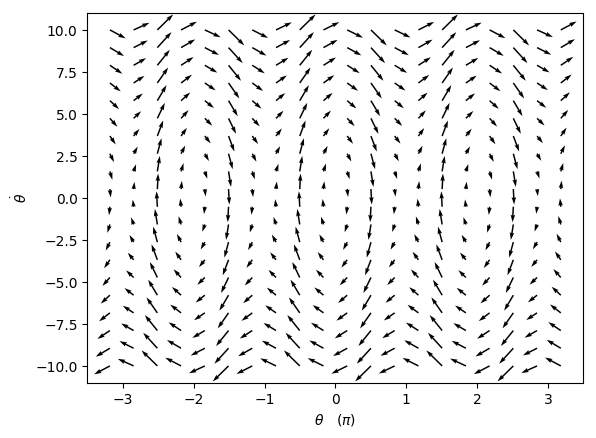

In [12]:
# plot the vector field of the phase portrait using the derivative of θ, ω
using LaTeXStrings
quiver(pθ/π, pω, pu, pv)
xlabel(L"\theta  \quad (\pi)");
ylabel(L"\dot{\theta}");

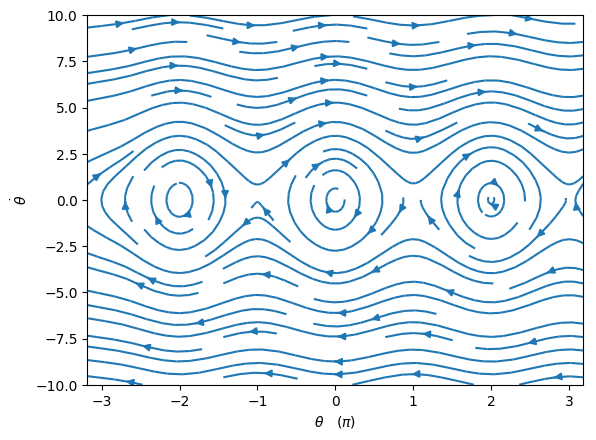

In [13]:
# we can view the phase portrait with stream lines, which looks like the original paths in the phase plot
streamplot(pθ/π, pω, pu, pv)
xlabel(L"\theta  \quad (\pi)");
ylabel(L"\dot{\theta} ");

## References
1. [Ari Seff. _What is Automatic Differentiation?_](https://www.youtube.com/watch?v=wG_nF1awSSY)
2. [ArchQuant. _Automatic Differentiation Explained with Example_](https://www.youtube.com/watch?v=jS-0aAamC64&t=579s)